In [159]:
using Pkg
Pkg.add("Plots")
Pkg.add("MLJEnsembles")
Pkg.add("XGBoost")
Pkg.add("Tables")

   Resolving package versions...
  No Changes to `C:\Users\Antoine\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Antoine\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Antoine\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Antoine\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Antoine\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Antoine\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Antoine\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Antoine\.julia\environments\v1.10\Manifest.toml`


In [206]:
using CSV, DataFrames, Statistics, Dates, Plots, LinearAlgebra, DecisionTree, Random, MLJ, MLJEnsembles,XGBoost


In [207]:
trainData = CSV.read("../../data/train.csv", DataFrame)
testData = CSV.read("../../data/test.csv", DataFrame)
first(trainData, 5)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2023,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"
2,2020,VUS_petit,4,2,integrale,automatique,"9,80041666666667"
3,2021,voiture_compacte,6,"3,3",propulsion,automatique,"11,7605"
4,2023,voiture_deux_places,8,5,integrale,automatique,"13,0672222222222"
5,2022,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"


In [208]:
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => ".")) 

testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))

150-element Vector{Float64}:
 2.5
 2.5
 2.5
 2.0
 5.8
 5.0
 5.0
 2.4
 3.5
 5.2
 5.2
 5.9
 2.0
 ⋮
 1.6
 3.3
 5.0
 2.0
 2.0
 1.6
 2.0
 2.0
 3.0
 3.0
 1.5
 2.0

In [209]:
trainData[!,:volume_gaz] = trainData[!,:nombre_cylindres] .* trainData[!,:cylindree]

testData[!,:volume_gaz] = testData[!,:nombre_cylindres] .* testData[!,:cylindree]

150-element Vector{Float64}:
 10.0
 10.0
 10.0
  8.0
 46.4
 40.0
 40.0
  9.6
 21.0
 52.0
 52.0
 70.80000000000001
  8.0
  ⋮
  6.4
 19.799999999999997
 40.0
  8.0
  8.0
  6.4
  8.0
  8.0
 18.0
 18.0
  4.5
  8.0

In [210]:
# Feature engineering on trainData
trainData[!, :age] = year.(today()) .- trainData[!, :annee]
trainData[!, :cylindree_per_cylindre] = trainData[!, :cylindree] ./ trainData[!, :nombre_cylindres]
trainData[!, :volume_gaz_per_cylindre] = trainData[!, :volume_gaz] ./ trainData[!, :nombre_cylindres]

# Normalize the new features
trainData = normalize_column(trainData, :age)
trainData = normalize_column(trainData, :cylindree_per_cylindre)
trainData = normalize_column(trainData, :volume_gaz_per_cylindre)

# Feature engineering on trainData
testData[!, :age] = year.(today()) .- testData[!, :annee]
testData[!, :cylindree_per_cylindre] = testData[!, :cylindree] ./ testData[!, :nombre_cylindres]
testData[!, :volume_gaz_per_cylindre] = testData[!, :volume_gaz] ./ testData[!, :nombre_cylindres]

# Normalize the new features
testData = normalize_column(testData, :age)
testData = normalize_column(testData, :cylindree_per_cylindre)
testData = normalize_column(testData, :volume_gaz_per_cylindre)


Row,annee,type,nombre_cylindres,cylindree,transmission,boite,volume_gaz,age,cylindree_per_cylindre,volume_gaz_per_cylindre
,Int64,String31,Int64,Float64,String15,String15,Float64,Float64,Float64,Float64
1,2014,voiture_moyenne,4,2.5,traction,manuelle,10.0,1.53728,0.930312,-0.372358
2,2014,voiture_moyenne,4,2.5,traction,automatique,10.0,1.53728,0.930312,-0.372358
3,2014,VUS_petit,4,2.5,traction,automatique,10.0,1.53728,0.930312,-0.372358
4,2014,VUS_petit,4,2.0,4x4,automatique,8.0,1.53728,-0.481343,-0.739816
5,2014,voiture_sous_compacte,8,5.8,propulsion,manuelle,46.4,1.53728,2.05964,2.05287
6,2014,voiture_sous_compacte,8,5.0,propulsion,automatique,40.0,1.53728,0.930312,1.46493
7,2014,voiture_sous_compacte,8,5.0,propulsion,manuelle,40.0,1.53728,0.930312,1.46493
8,2014,VUS_petit,4,2.4,4x4,automatique,9.6,1.53728,0.647981,-0.44585
9,2014,VUS_petit,6,3.5,integrale,automatique,21.0,1.53728,0.45976,0.362559


In [213]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end


function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    return encoded_data
end

function removeRows(data)
    return select!(data, Not([:type, :transmission, :boite, :nombre_cylindres]))
end

function normalize_column(data, column)
    data[!, column] = (data[!, column] .- mean(data[!, column])) ./ std(data[!, column])
    return data
end

function norm_cols(data)
    normalized_data = deepcopy(data)
    normalized_data = normalize_column(normalized_data, :cylindree)
    normalized_data = normalize_column(normalized_data, :volume_gaz)
    return normalized_data
end


function train_test_split(data, test_size=0.2, shuffle=true)
    n = size(data, 1)
    test_size = floor(Int, n * test_size)
    
    if shuffle
        indices = randperm(n)
    else
        indices = 1:n
    end
    
    test_indices = indices[1:test_size]
    train_indices = indices[test_size+1:end]
    
    train_data = data[train_indices, :]
    test_data = data[test_indices, :]
    
    return train_data, test_data
end

train_test_split (generic function with 3 methods)

In [214]:
X_train =  Matrix(trainData[:, Not(:consommation)])
y_train = trainData.consommation
X_test = Matrix(testData)

150×10 Matrix{Any}:
 2014  "voiture_moyenne"        …   1.53728   0.930312  -0.372358
 2014  "voiture_moyenne"            1.53728   0.930312  -0.372358
 2014  "VUS_petit"                  1.53728   0.930312  -0.372358
 2014  "VUS_petit"                  1.53728  -0.481343  -0.739816
 2014  "voiture_sous_compacte"      1.53728   2.05964    2.05287
 2014  "voiture_sous_compacte"  …   1.53728   0.930312   1.46493
 2014  "voiture_sous_compacte"      1.53728   0.930312   1.46493
 2014  "VUS_petit"                  1.53728   0.647981  -0.44585
 2014  "VUS_petit"                  1.53728   0.45976    0.362559
 2014  "voiture_deux_places"        1.53728  -0.255478   1.61192
 2014  "voiture_deux_places"    …   1.53728  -0.255478   1.61192
 2014  "voiture_sous_compacte"      1.53728  -0.575453   2.12636
 2014  "VUS_petit"                  1.53728  -0.481343  -0.739816
    ⋮                                     ⋱                       
 2023  "VUS_petit"                 -1.48798  -1.61067   -1.033

In [167]:
function eval(model, X)
    res = []
    for i in 1:100
        newModel = deepcopy(model)
        train, test= train_test_split(X,0.2)
        X_train =  Matrix(train[:, Not(:consommation)])
        y_train = train.consommation
        X_test = Matrix(test[:, Not(:consommation)])
        y_test = test.consommation
        DecisionTree.fit!(newModel, X_train, y_train)
        y_pred = DecisionTree.predict(newModel, X_test)
        push!(res,sqrt(mean((y_pred - test.consommation).^2)))

        if i % 10 == 0
            println("Iteration $i/100")
        end
    end
    println("Mean RMSE: ", mean(res))
    return histogram(res, bins=20)
end

eval (generic function with 2 methods)

Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
Iteration 100/100
Mean RMSE: 0.9636302438141869


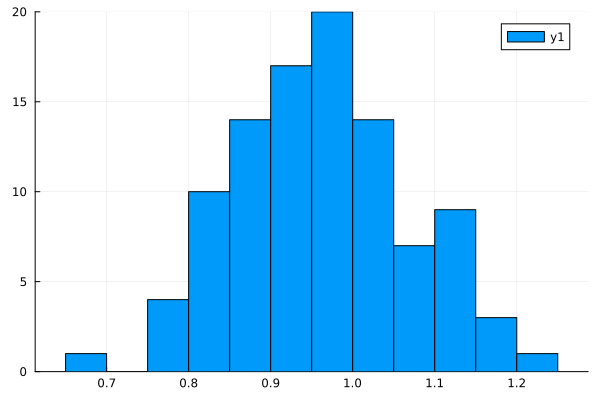

In [168]:
model0 = DecisionTreeRegressor()
X_train = trainData
eval(model0, X_train)

Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
Iteration 100/100
Mean RMSE: 0.8586436341665667


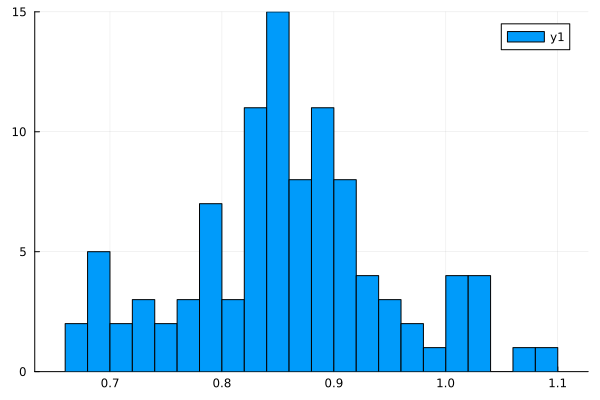

In [215]:
model1 = RandomForestRegressor(n_subfeatures=12, n_trees=10,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)

X_train = encode_data(trainData)
eval(model1, X_train)

Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
Iteration 100/100
Mean RMSE: 0.8585597490769469


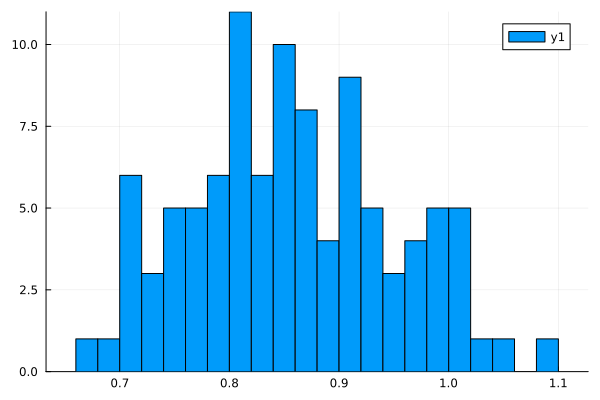

In [216]:
model2 = RandomForestRegressor(n_subfeatures=23, n_trees=100,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)

#X_train = combine(x -> mean(x.consommation), groupby(trainData, [ :annee, :cylindree, :volume_gaz, :type, :transmission, :boite, :nombre_cylindres]))

X_train = encode_data(X_train)
#rename!(X_train, :x1 => :consommation)
eval(model2, X_train)

Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
Iteration 100/100
Mean RMSE: 0.8483354106497363


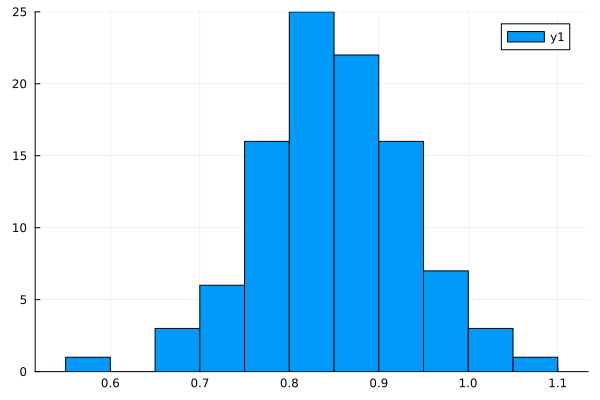

In [217]:
model3 = RandomForestRegressor(n_subfeatures=10, n_trees=100,min_samples_leaf=2,min_purity_increase=0.01, max_depth=10, min_samples_split=6)

X_train = encode_data(trainData)


X_train.cylindree = X_train.cylindree .- minimum(X_train.cylindree)
X_train.volume_gaz = X_train.volume_gaz .- minimum(X_train.volume_gaz)
X_train.annee = X_train.annee .-minimum(X_train.annee)

eval(model3, X_train)

In [191]:
function grid_search(model, X, param_grid)
    best_model = nothing
    best_score = Inf
    best_params = nothing

    for params in param_grid
        score = 0
        model_instance = model(;params...)
        for i in 1:100
            model_instance = deepcopy(model(;params...))
            train, test = train_test_split(X, 0.2)
            X_train = Matrix(train[:, Not(:consommation)])
            y_train = train.consommation
            X_test = Matrix(test[:, Not(:consommation)])
            y_test = test.consommation

            DecisionTree.fit!(model_instance, X_train, y_train)
            y_pred = DecisionTree.predict(model_instance, X_test)
            score += sqrt(mean((y_pred - y_test).^2))
        end
        score/=100
        println(score)
        if score < best_score
            best_score = score
            best_model = deepcopy(model_instance)
            best_params = params
        end
    end

    println("Best Score: ", best_score)
    println("Best Params: ", best_params)
    return best_model, best_params
end

X_train = encode_data(trainData)
model = RandomForestRegressor
best_model, best_params = grid_search(model, X_train, param_grid)

0.8952386469625446
0.9509478473666642
0.9154629952362626
0.9782674539756584
0.9154136167647977
0.9014670141007933
0.9123036755202317
0.9654723647372525
0.8913790898341972
0.8576116997798358
0.9585961805648898
0.9345807659709999
0.8475710893464459
0.9751267932470017
0.9184770071106645
0.9550367372090045
0.9417622755965208
0.8480908429449272
0.9045187801922827
0.8441405769553427
0.848499708626716
0.9820899133772926
0.9023205708567965
0.884864674857718
0.8950001062761572
Best Score: 0.8441405769553427
Best Params: (n_subfeatures = 10.0, n_trees = 200, partial_sampling = 1.0, max_depth = 10, min_samples_leaf = 3, min_samples_split = 4, min_purity_increase = 0.01)


(RandomForestRegressor
n_trees:             200
n_subfeatures:       10
partial_sampling:    1.0
max_depth:           10
min_samples_leaf:    3
min_samples_split:   4
min_purity_increase: 0.01
ensemble:            Ensemble of Decision Trees
Trees:      200
Avg Leaves: 53.49
Avg Depth:  9.8, (n_subfeatures = 10.0, n_trees = 200, partial_sampling = 1.0, max_depth = 10, min_samples_leaf = 3, min_samples_split = 4, min_purity_increase = 0.01))

In [189]:
param_grid = [
    (
        n_subfeatures = rand([-1, round(sqrt(23)), 5, 10, 15]),
        n_trees = rand(10:10:200),
        partial_sampling = rand(0.5:0.1:1.0),
        max_depth = rand([5, 10, 15, 20]),
        min_samples_leaf = rand(1:10),
        min_samples_split = rand(2:10),
        min_purity_increase = rand(0.0:0.01:0.1),
    ) for _ in 1:25
]

25-element Vector{@NamedTuple{n_subfeatures::Float64, n_trees::Int64, partial_sampling::Float64, max_depth::Int64, min_samples_leaf::Int64, min_samples_split::Int64, min_purity_increase::Float64}}:
 (n_subfeatures = 10.0, n_trees = 120, partial_sampling = 1.0, max_depth = 5, min_samples_leaf = 7, min_samples_split = 7, min_purity_increase = 0.01)
 (n_subfeatures = 5.0, n_trees = 70, partial_sampling = 0.5, max_depth = 20, min_samples_leaf = 5, min_samples_split = 3, min_purity_increase = 0.01)
 (n_subfeatures = 15.0, n_trees = 40, partial_sampling = 0.9, max_depth = 10, min_samples_leaf = 10, min_samples_split = 10, min_purity_increase = 0.08)
 (n_subfeatures = 5.0, n_trees = 200, partial_sampling = 0.6, max_depth = 5, min_samples_leaf = 6, min_samples_split = 8, min_purity_increase = 0.05)
 (n_subfeatures = 5.0, n_trees = 60, partial_sampling = 0.6, max_depth = 20, min_samples_leaf = 2, min_samples_split = 3, min_purity_increase = 0.06)
 (n_subfeatures = 10.0, n_trees = 40, partial_sa

Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
Iteration 100/100
Mean RMSE: 0.861383167802


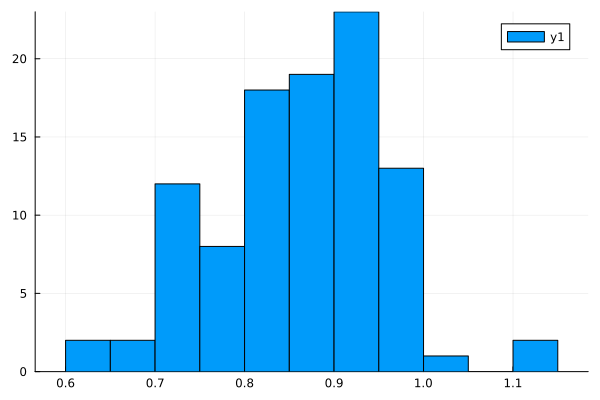

In [172]:
model4 = RandomForestRegressor(n_subfeatures=15, n_trees=200, min_samples_leaf=1, min_purity_increase=0.0, max_depth=15, min_samples_split=4)

X_train = encode_data(trainData)
#= X_train = norm_cols(X_train)
 =#
eval(model4, X_train)

In [173]:
function decisionTree_remise(X_train ,y_train,  X_test, max_depth)
    model = DecisionTreeRegressor(max_depth=max_depth)
    fit!(model, X_train, y_train) #peut etre normaliser sur tout les données, pas justr sur les données d'entrainement
    ychap =  predict(model, X_test)  
    return ychap
end

decisionTree_remise (generic function with 1 method)

In [202]:
param = (n_subfeatures = 10.0, n_trees = 200, partial_sampling = 1.0, max_depth = 10, min_samples_leaf = 3, min_samples_split = 4, min_purity_increase = 0.01)


function randomForest_remise(X_train ,y_train,  X_test, params)
    model = RandomForestRegressor(;params...)
    DecisionTree.fit!(model, Matrix(X_train), y_train) #peut etre normaliser sur tout les données, pas justr sur les données d'entrainement
    ychap =  predict(model, Matrix(X_test))  
    return ychap
end

randomForest_remise (generic function with 1 method)

In [221]:
X_train = encode_data(trainData)[:, Not(:consommation)]


Row,annee,type,nombre_cylindres,cylindree,transmission,boite,volume_gaz,age,cylindree_per_cylindre,volume_gaz_per_cylindre,voiture_moyenne,VUS_petit,voiture_compacte,voiture_deux_places,voiture_minicompacte,VUS_standard,monospace,voiture_sous_compacte,camionnette_petit,break_petit,voiture_grande,camionnette_standard,break_moyen,integrale,propulsion,traction,4x4,automatique,manuelle
,Int64,String31,Int64,Float64,String15,String15,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2023,voiture_moyenne,8,4.4,integrale,automatique,35.2,-1.18235,0.155019,1.24022,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,2020,VUS_petit,4,2.0,integrale,automatique,8.0,-0.250279,-0.531132,-0.748147,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,2021,voiture_compacte,6,3.3,propulsion,automatique,19.8,-0.560971,0.155019,0.328884,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,2023,voiture_deux_places,8,5.0,integrale,automatique,40.0,-1.18235,1.18425,1.73731,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
5,2022,voiture_moyenne,8,4.4,integrale,automatique,35.2,-0.871662,0.155019,1.24022,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
6,2022,voiture_moyenne,8,4.4,integrale,automatique,35.2,-0.871662,0.155019,1.24022,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
7,2022,voiture_minicompacte,3,1.5,traction,automatique,4.5,-0.871662,-0.531132,-1.16239,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
8,2024,voiture_minicompacte,3,1.5,traction,manuelle,4.5,-1.49304,-0.531132,-1.16239,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
9,2020,VUS_standard,6,3.8,integrale,automatique,22.8,-0.250279,1.2986,0.743126,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [220]:
X_test = encode_data(testData)


Row,annee,type,nombre_cylindres,cylindree,transmission,boite,volume_gaz,age,cylindree_per_cylindre,volume_gaz_per_cylindre,voiture_moyenne,VUS_petit,voiture_sous_compacte,voiture_deux_places,camionnette_standard,VUS_standard,voiture_compacte,voiture_grande,voiture_minicompacte,monospace,break_petit,break_moyen,camionnette_petit,traction,4x4,propulsion,integrale,manuelle,automatique
,Int64,String31,Int64,Float64,String15,String15,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2014,voiture_moyenne,4,2.5,traction,manuelle,10.0,1.53728,0.930312,-0.372358,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,2014,voiture_moyenne,4,2.5,traction,automatique,10.0,1.53728,0.930312,-0.372358,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,2014,VUS_petit,4,2.5,traction,automatique,10.0,1.53728,0.930312,-0.372358,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,2014,VUS_petit,4,2.0,4x4,automatique,8.0,1.53728,-0.481343,-0.739816,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5,2014,voiture_sous_compacte,8,5.8,propulsion,manuelle,46.4,1.53728,2.05964,2.05287,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
6,2014,voiture_sous_compacte,8,5.0,propulsion,automatique,40.0,1.53728,0.930312,1.46493,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
7,2014,voiture_sous_compacte,8,5.0,propulsion,manuelle,40.0,1.53728,0.930312,1.46493,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
8,2014,VUS_petit,4,2.4,4x4,automatique,9.6,1.53728,0.647981,-0.44585,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
9,2014,VUS_petit,6,3.5,integrale,automatique,21.0,1.53728,0.45976,0.362559,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [222]:

X_train.cylindree = X_train.cylindree .- minimum(X_train.cylindree)
X_train.volume_gaz = X_train.volume_gaz .- minimum(X_train.volume_gaz)
X_train.annee = X_train.annee .-minimum(X_train.annee)

X_test.cylindree = X_test.cylindree .- minimum(X_test.cylindree)
X_test.volume_gaz = X_test.volume_gaz .- minimum(X_test.volume_gaz)
X_test.annee = X_test.annee .-minimum(X_test.annee)


res = randomForest_remise(X_train ,y_train,  X_test, param)
testData.consommation = res

150-element Vector{Float64}:
  8.817382826503612
  9.006463711824736
  9.796460746299665
  9.640582194600965
 14.10903804124762
 13.85535122853742
 13.722690661944144
  9.895353616405488
 11.569774952329835
 14.821035309717699
 14.821035309717699
 15.025377312390278
  9.453710931107391
  ⋮
  7.822428372242432
 11.279229847503009
 12.860451406358145
  9.919463443469356
  9.324007329824084
  7.919080371569844
  8.706633078548693
  9.30761089281924
 11.136369160948188
 11.387775450991546
  7.751951158898481
  8.907157170942256

In [223]:
id = 1:150

df_pred = DataFrame(id=id, consommation=res)

CSV.write("benchmark12.csv", df_pred)

"benchmark12.csv"